# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data= pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.duplicated().sum()

0

In [5]:
data.isnull().sum()

file_name    0
real_age     0
dtype: int64

Не выявлено дубликатов или пропусков, можем работать с дата фреймом дальше

In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Аномалий не зафиксировано. Также можем заметить что большая часть людей у нас в возрасте от 20 до 41 года

Выведем размер выборки

In [7]:
data.shape

(7591, 2)

Построим график распеределения возраста

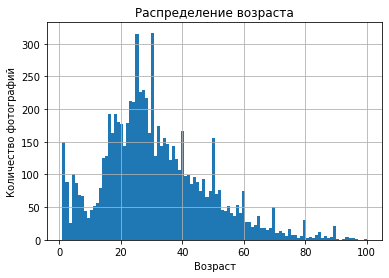

In [8]:
data.hist(bins=100)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

Found 10 validated image filenames.
['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']


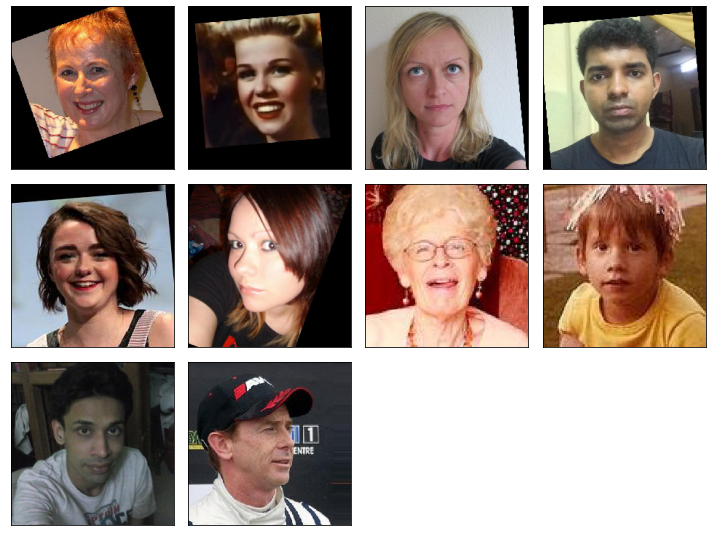

In [9]:
image_dir = '/datasets/faces/final_files'
data_generator = ImageDataGenerator(rescale=1./255)
first_10_files = data['file_name'][:10]
images_data = data_generator.flow_from_dataframe(
    dataframe=data[data['file_name'].isin(first_10_files)],
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=10)
images, labels = next(images_data)
print(images_data.filenames)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**
Выборка составляет 7591 фотографии

Больше всего фотографий людей в возрасте от 20 до 41 года. Также заметно большое количество детей.

Вывели первые 10 фотографий. На обучение модели может повлиять качество фотографии, как например у первой. Возможно влияние окажут различные головные уборы и очки.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rotation_range = 40, horizontal_flip=True, rescale=1./255, validation_split=0.25)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])


    return model


def train_model(model,train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, epochs=15, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
356/356 - 116s - loss: 218.5730 - mean_absolute_error: 10.9797 - val_loss: 747.0453 - val_mean_absolute_error: 22.3646
Epoch 2/15
356/356 - 91s - loss: 112.8414 - mean_absolute_error: 8.0571 - val_loss: 264.3288 - val_mean_absolute_error: 12.1791
Epoch 3/15
356/356 - 91s - loss: 97.0811 - mean_absolute_error: 7.4641 - val_loss: 107.6154 - val_mean_absolute_error: 7.9436
Epoch 4/15
356/356 - 91s - loss: 78.0439 - mean_absolute_error: 6.7010 - val_loss: 90.9026 - val_mean_absolute_error: 7.2116
Epoch 5/15
356/356 - 91s - loss: 67.5155 - mean_absolute_error: 6.3009 - val_loss: 88.2655 - val_mean_absolute_error: 7.3616
Epoch 6/15
356/356 - 91s - loss: 61.4211 - mean_absolute_error: 5.9658 - val_loss: 97.8512 - val_mean_absolute_error: 7.6100
Epoch 7/15
356/356 - 91s - loss: 53.3769 - mean_absolute_error: 5.6112 - val_loss: 109.0329 - val_mean_absolute_error: 8.2054
Epoch 8/15
356/356 - 91s - loss: 48.0160 - mean_absolute_error: 5.3049 - val_loss: 78.0619 - val_mean_absolute_error: 6.6348
Epoch 9/15
356/356 - 91s - loss: 44.1968 - mean_absolute_error: 5.0760 - val_loss: 70.2268 - val_mean_absolute_error: 6.2531
Epoch 10/15
356/356 - 91s - loss: 40.2914 - mean_absolute_error: 4.8815 - val_loss: 76.5020 - val_mean_absolute_error: 6.4308
Epoch 11/15
356/356 - 91s - loss: 36.4183 - mean_absolute_error: 4.6284 - val_loss: 77.7725 - val_mean_absolute_error: 6.7277
Epoch 12/15
356/356 - 91s - loss: 33.5980 - mean_absolute_error: 4.4466 - val_loss: 73.5483 - val_mean_absolute_error: 6.3614
Epoch 13/15
356/356 - 91s - loss: 28.2088 - mean_absolute_error: 4.1115 - val_loss: 73.2133 - val_mean_absolute_error: 6.4240
Epoch 14/15
356/356 - 91s - loss: 27.0738 - mean_absolute_error: 4.0025 - val_loss: 79.4428 - val_mean_absolute_error: 6.5964
Epoch 15/15
356/356 - 91s - loss: 27.2806 - mean_absolute_error: 4.0079 - val_loss: 74.7556 - val_mean_absolute_error: 6.6126
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 74.7556 - mean_absolute_error: 6.6126
Test MAE: 6.6126




```

**Вывод**
Добились значения MAE на тестовой выборке 6.6126, что удовлетворяет нашим условиям

## Анализ обученной модели

Напишите выводы здесь

Модель достаточно хорошо справляется с поставленной задачей, имея погрешность всего в 6,5 лет, что позволит разбить клиентов на верные возрастные группы. 

Однако с задачей контроля добросовестности кассиров при продаже алкоголя модель  не может справиться полностью, тк погрешность в 6,5 лет, при минимальной пороге продажи 18 лет, сильно повышает возможность ошибки.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы